# 2D Panel Method with Boundary Layer Correction vs. OpenFOAM Simulation

## Bob Forcha
## MEA 6226
## GW SEAS
## Spring 2017

Throughout the semester, the building blocks of 2 dimensional panel methods have been presented, culminating in the development of a potential flow based solver for airfoils, written in Python. While these methods can yield useful information about the lift generated by an airfoil, they also have serious limitations, such as inability to predict drag, flow separation, or viscous effects at the surface of the airfoil.

It is the goal of this project to introduce a boundary layer modeling technique which will correct some of these shortcomings, and compare its results with a simple CFD simulation run in the open source software OpenFOAM. 

## 2D panel method solver

The first step in the process is to write a panel method solver, as has been done in the lessons throughout the course. This report will not go into detail on this portion of the project, as it has been thoroughly covered over the last few lessons. One note is that a new function for defining the panels has been added to resources.ipynb, which takes in a nacaXXXX.dat file generated on airfoiltools.com and returns a list of Panel objects discretizing the airfoil geometry. Also, all solver functions from previous lessons have been combined into one naca_solver function, which takes a .dat file with the x- and y-coordinates of the airfoil profile, and an angle of attack as inputs, and returns a list containing the panels, a 50x50 mesh grid in x and y, the velocity profile, and the pressure field surrounding the airfoil.

As an example, the solver is run with a NACA0012 symmetric airfoil with an AoA of $0^\text{o}$:

In [150]:
# imports and class/function definitions
%run res/resources.ipynb

In [151]:
# run solver for naca0012 airfoil with AoA = 1
alpha = 0.0
sol = naca_solver('naca2412.dat', alpha)

In [152]:
# organize
panels = sol[0]
X, Y = sol[1], sol[2]
u, v = sol[3], sol[4]
cp = sol[5]

---> sum of source/sink strengths: 0.0018891821037968198
lift coefficient: CL = 0.121


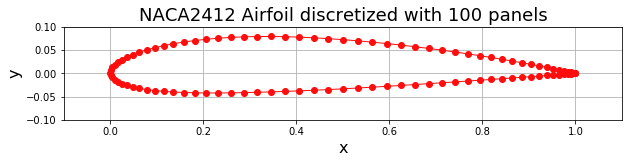

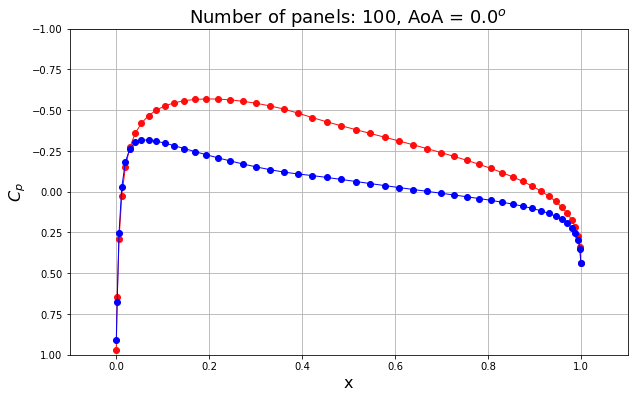

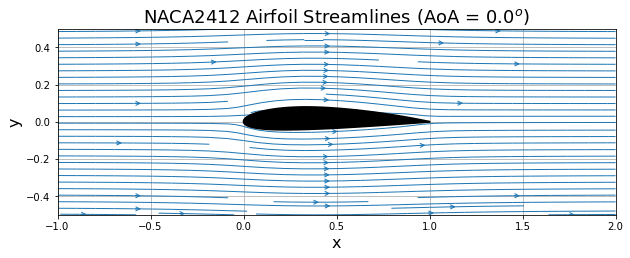

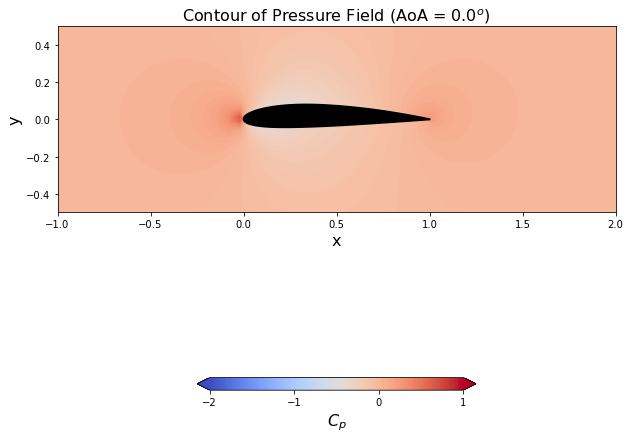

In [161]:
# plot results
# panels
size=10
plt.figure(figsize=(size, size))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot([panel.xa for panel in panels], [panel.ya for panel in panels],
         color='#FF0D0D', linewidth=1, marker='o', markersize=6)
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)
plt.title('NACA2412 Airfoil discretized with {} panels'.format(panels.size), fontsize=18);

# C_p vs x
plt.figure(figsize=(size, 6))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels if panel.loc == 'upper'],
         [panel.cp for panel in panels if panel.loc == 'upper'],
         color='#FF0D0D', linewidth=1, marker='o', markersize=6)
plt.plot([panel.xc for panel in panels if panel.loc == 'lower'],
         [panel.cp for panel in panels if panel.loc == 'lower'],
         color='b', linewidth=1, marker='o', markersize=6)
plt.xlim(-0.1, 1.1)
plt.ylim(1.0, -1.0)
plt.title('Number of panels: {}, AoA = ${}^o$'.format(panels.size, alpha), fontsize=18);

# velocity field
plt.figure(figsize=(size, size))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.streamplot(X, Y, u, v, density=1, linewidth=1, arrowsize=1, arrowstyle='->')
plt.fill([panel.xc for panel in panels], [panel.yc for panel in panels],
         color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled', adjustable='box')
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.title('NACA2412 Airfoil Streamlines (AoA = ${}^o$)'.format(alpha), fontsize=18);

plt.figure(figsize=(size, size))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
contf = plt.contourf(X, Y, cp, cmap=plt.cm.coolwarm, levels=np.linspace(-2.0, 1.0, 100), extend='both')
cbar = plt.colorbar(contf, orientation='horizontal', shrink=0.5, pad=0.1, ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
plt.fill([panel.xc for panel in panels], [panel.yc for panel in panels], color='k', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled', adjustable='box')
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.title('Contour of Pressure Field (AoA = ${}^o$)'.format(alpha), fontsize=16);

# check accuracy
accuracy = sum(panel.sigma*panel.length for panel in panels)
print('---> sum of source/sink strengths: {}'.format(accuracy))

# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels)
        - min(panel.xa for panel in panels))
cl = (gamma*sum(panel.length for panel in panels)
      / (0.5*fs.u_inf*c))
print('lift coefficient: CL = {:0.3f}'.format(cl))

## Boundary Layer Correction

Now, the boundary layer is analyzed using the results of the inviscid solver.  Let's define some terms that will be used in this analysis:

$\delta$ is the boundary layer thickness, where $u = 0.99U_\delta$.

$U_\delta$ is the tangential velocity for each panel obtained from our previous analysis.

$\frac{\partial P}{\partial x}$ is the pressure gradient along the surface of the airfoil.  It's important to note that this assumes $P$ is constant through the thickness of the boundary layer.

$\tau_w$ is the shear stress along the surface due to viscous effects.

### Blasius Solution

To begin, we'll use the Blasius solution for a flat plate. We know it won't be perfect, but it's a good jumping off point. We're familiar with the form:

$$2\frac{d^3 f}{d\eta^3} + f\left(\eta\right)\frac{d^2 f}{d\eta^2} = 0$$